In [1]:
import cv2
import pyrealsense2 as rs
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

## L and R images with Depth and Colour Img

In [2]:
def display(inp):
    i = len(inp)
    
    outs = []
    for x in inp:
        out = np.asarray(x.get_data())
        outs.append(out)
        
    fig, ax = plt.subplots(1,i,figsize=(20,20))
    for x in range(i):
        ax[x].imshow(outs[x])
        ax[x].axis("off")
    plt.show()

In [3]:
ctx = rs.context()
device = ctx.devices[0]
serial_number = device.get_info(rs.camera_info.serial_number)
config = rs.config()
config.enable_device(serial_number)

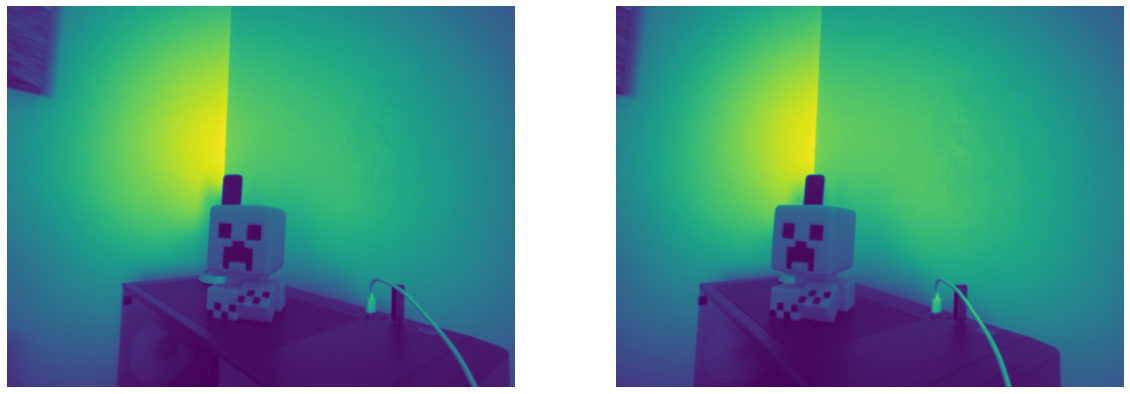

In [7]:
images = []

# getting left and right image
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.infrared, 1, 640, 480, rs.format.y8, 6) # left
config.enable_stream(rs.stream.infrared, 2, 640, 480, rs.format.y8, 6) # right
profile = pipeline.start(config)
depth_sensor = device.first_depth_sensor()
depth_sensor.set_option(rs.option.emitter_enabled, 0.0)

time.sleep(3)

# Skip 5 first frames to give the Auto-Exposure time to adjust
for index in range(5):
    pipeline.wait_for_frames()

frames = pipeline.wait_for_frames()
display(frames)
images.append(np.asarray(frames[0].get_data()))
images.append(np.asarray(frames[1].get_data()))

In [8]:
cv2.imwrite("2l.png", images[0])
cv2.imwrite("2r.png", images[1])

True

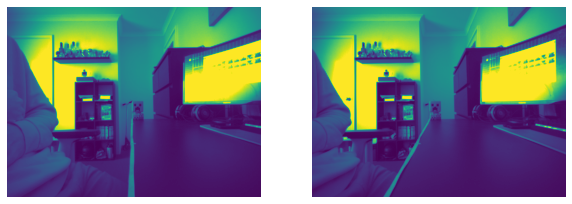

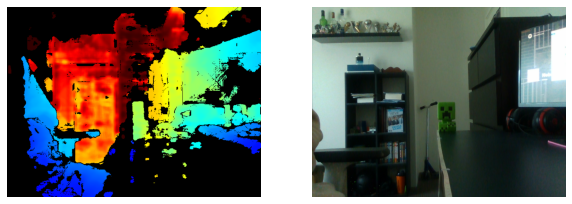

In [18]:
images = []

# getting left and right image
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.infrared, 1, 640, 480, rs.format.y8, 6) # left
config.enable_stream(rs.stream.infrared, 2, 640, 480, rs.format.y8, 6) # right
profile = pipeline.start(config)
depth_sensor = device.first_depth_sensor()
depth_sensor.set_option(rs.option.emitter_enabled, 0.0)

time.sleep(2)

# Skip 5 first frames to give the Auto-Exposure time to adjust
for index in range(5):
    pipeline.wait_for_frames()

frames = pipeline.wait_for_frames()
display(frames)
images.append(np.asarray(frames[0].get_data()))
images.append(np.asarray(frames[1].get_data()))

# getting depth and colour image
pipeline.stop()
pipeline = rs.pipeline()
config = rs.config()
profile = pipeline.start(config)
depth_sensor = device.first_depth_sensor()
depth_sensor.set_option(rs.option.emitter_enabled, 1.0)

time.sleep(2)

# Skip 5 first frames to give the Auto-Exposure time to adjust
for index in range(5):
    pipeline.wait_for_frames()

frames = pipeline.wait_for_frames()
depth = frames.get_depth_frame()
color_frame = frames.get_color_frame()
colorizer = rs.colorizer()
depth_color_frame = colorizer.colorize(depth)
#color_frame = cv2.cvtColor(color_frame, cv2.COLOR_BGR2RGB)
display([depth_color_frame, color_frame])
images.append(np.asarray(depth_color_frame.get_data()))
images.append(cv2.cvtColor(np.asarray(color_frame.get_data()), cv2.COLOR_BGR2RGB))

In [19]:
pairnumber = 0

In [20]:
for idx, img in enumerate(images[:-1]):
    cv2.imwrite("dimension_testing/ImagePair{}-{}l.png".format(pairnumber, idx), img[0])
    cv2.imwrite("dimension_testing/ImagePair{}-{}r.png".format(pairnumber, idx), img[1])
    idx += 1

In [34]:
pipeline.stop() 

## Video

In [2]:
# has an fps of 30 with 640x480
# only fps of 6 with 1280x720
ctx = rs.context()
device = ctx.devices[0]
serial_number = device.get_info(rs.camera_info.serial_number)
config = rs.config()
config.enable_device(serial_number)

pipeline = rs.pipeline()
config.enable_stream(rs.stream.infrared, 1, 640, 480, rs.format.y8, framerate=30) # left (camera, number, sizse, format, fps)
config.enable_stream(rs.stream.infrared, 2, 640, 480, rs.format.y8, framerate=30) # right
#config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 12)

profile = pipeline.start(config)

depth_sensor = device.first_depth_sensor()
depth_sensor.set_option(rs.option.emitter_enabled, 0.0)

colorizer = rs.colorizer()

In [11]:
# cant save depth, too much memory to store then

left_frames = []
right_frames = []
#depth_frames = []

while True:
    frames = pipeline.wait_for_frames()
    frames.keep()
    
    #D = frames.get_depth_frame()
    #D = np.asanyarray(colorizer.colorize(D).get_data())  
    L = frames[0]
    R = frames[1]
    L = np.asanyarray(L.get_data())
    R =  np.asanyarray(R.get_data())
    
    cv2.imshow("Left", L)
    #cv2.imshow("Right", R)
    #cv2.imshow("depth", D)
    
    left_frames.append(L)
    right_frames.append(R)
    #depth_frames.append(D)
    
    if cv2.waitKey(20) == ord('q'):
        break   

# we also need to close the video and destroy all Windows
cv2.destroyAllWindows()

In [12]:
size = (640, 480)
fps = 30.0
outL = cv2.VideoWriter('stabilized videos/vid6.mp4', cv2.VideoWriter_fourcc(*'MP42'), fps, size)
outR = cv2.VideoWriter('stabilized videos/vid6-right.mp4', cv2.VideoWriter_fourcc(*'MP42'), fps, size)
#outD = cv2.VideoWriter('depth.mp4', cv2.VideoWriter_fourcc(*'MP42'), fps, size)
 
for i in range(len(left_frames)):
    outL.write(left_frames[i])
outL.release()

for i in range(len(right_frames)):
    outR.write(right_frames[i])
outR.release()

#for i in range(len(depth_frames)):
#    outD.write(depth_frames[i])
#outD.release()

## Processing filters

In [35]:
pipeline = rs.pipeline()  # type: rs.pipeline
config = rs.config()
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 60)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 60)
profile = pipeline.start(config)  # type: rs.pipeline_profile
device = profile.get_device()  # type: rs.device
depth_sensor = device.first_depth_sensor()  # type: rs.depth_sensor

if depth_sensor.supports(rs.option.emitter_enabled):
    print('Enabling emitter...')
    depth_sensor.set_option(rs.option.emitter_enabled, 1.0)

print('-------------')
is_emitted_enabled = depth_sensor.get_option(rs.option.emitter_enabled)
print('Emitter Enabled? {}'.format(is_emitted_enabled))
print('-------------')

# Skip 5 first frames to give the Auto-Exposure time to adjust
for index in range(5):
    pipeline.wait_for_frames()
 
colorizer = rs.colorizer()
spatial = rs.spatial_filter()
spatial.set_option(rs.option.filter_magnitude, 5)
spatial.set_option(rs.option.filter_smooth_alpha, 1)
spatial.set_option(rs.option.filter_smooth_delta, 50)
spatial.set_option(rs.option.holes_fill, 3)
temporal = rs.temporal_filter()
decimation = rs.decimation_filter()
decimation.set_option(rs.option.filter_magnitude, 4)
hole_filling = rs.hole_filling_filter()

depth_to_disparity = rs.disparity_transform(False)
disparity_to_depth = rs.disparity_transform(False)

frames = []
for index in range(10):
    frameset = pipeline.wait_for_frames()
    frames.append(frameset.get_depth_frame())
# take the last frame and save it as a colored graph
colorized_depth = np.asanyarray(colorizer.colorize(frames[-1]).get_data())
plt.imshow(colorized_depth)
plt.savefig('depth_frame_before_filters.png')
frame = None
for index in range(len(frames)):
    frame = frames[index]
    #frame = decimation.process(frame)
    #frame = depth_to_disparity.process(frame)
    frame = spatial.process(frame)
    frame = temporal.process(frame)
    #frame = disparity_to_depth.process(frame)
    frame = hole_filling.process(frame)

colorized_depth = np.asanyarray(colorizer.colorize(frame).get_data())
depth_arr_np = np.asanyarray(frame.get_data())
print('depth at (342, 240): {}mm'.format(depth_arr_np[342,240]))
plt.imshow(colorized_depth)
plt.savefig('depth_frame_after_filters.png')
pipeline.stop()

RuntimeError: Couldn't resolve requests

## Calibration parameters:

In [ ]:
# Here are the calibration parameters from "Intel.Realsense.CustomRW" for Intel Realsense d435
# Calibration parameters from the device:

resolutionLeftRight: 1280 800

FocalLengthLeft: 640.590088 640.183533
PrincipalPointLeft: 637.286316 402.818481
DistortionLeft: -0.055629 0.063853 -0.000203 -0.000965 -0.020792

FocalLengthRight: 642.577454 642.286743
PrincipalPointRight: 648.905396 406.992188
DistortionRight: -0.056637 0.067119 -0.000290 -0.001725 -0.022515

RotationLeftRight:  0.999975 -0.002564 -0.006569
                    0.002552 0.999995 -0.001754
                    0.006574 0.001738 0.999977
TranslationLeftRight: -49.850437 -0.109076 0.017740

# Calibration parameters published on /camera/"camera"/camera_info for Intel Realsense d435

header:
seq: 869
stamp:
secs: 1552302510
nsecs: 879911038
frame_id: "camera_infra1_optical_frame"
height: 800
width: 1280
distortion_model: "plumb_bob"
D: [0.0, 0.0, 0.0, 0.0, 0.0]
K: [639.0849609375, 0.0, 644.4653930664062, 0.0, 639.0849609375, 364.2340393066406, 0.0, 0.0, 1.0]
R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
P: [639.0849609375, 0.0, 644.4653930664062, 0.0, 0.0, 639.0849609375, 364.2340393066406, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 0
binning_y: 0
roi:
x_offset: 0
y_offset: 0
height: 0
width: 0
do_rectify: False